<a href="https://colab.research.google.com/github/alaeddinehamroun/Recurrent-Neural-Networks/blob/main/Building_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired from [Sequence Models course on coursera by Andrew Ng](https://www.coursera.org/learn/nlp-sequence-models?specialization=deep-learning)


In [ ]:
import numpy as np

In [ ]:
def softmax(x):
  e_x  = np.exp(x -np.max(x))
  return e_x /e_x.sum(axis=0)

In [ ]:
def sigmoid(x):
  return 1 / (1+ np.exp(-x))

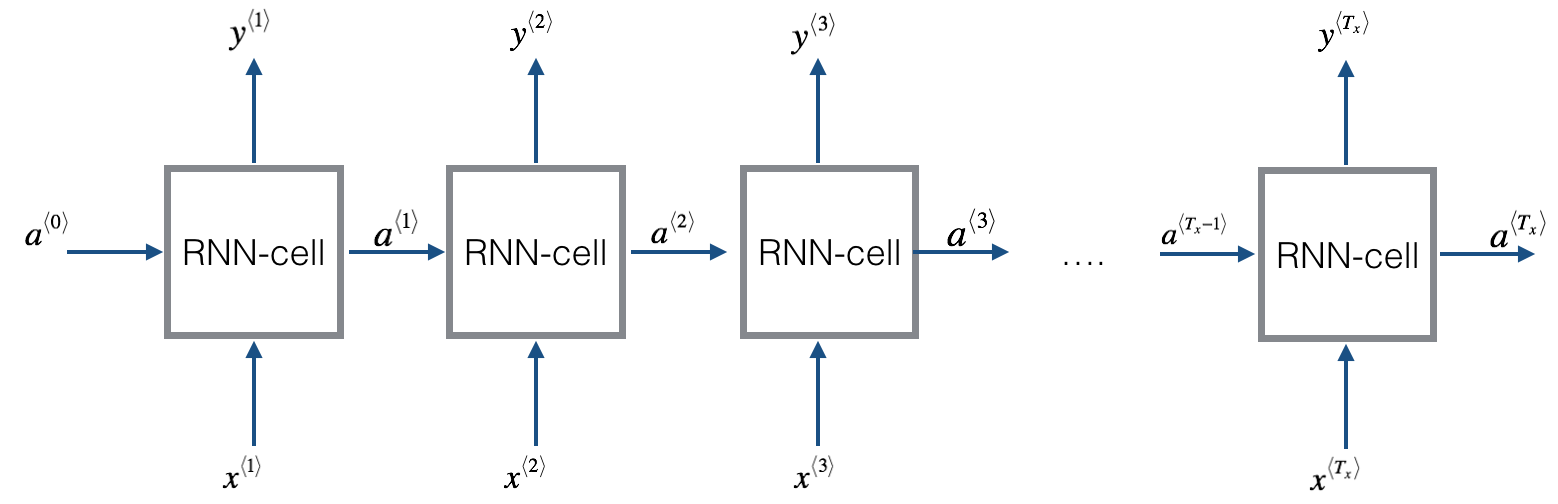

# Forward Propagation for the Basic Recurrent Neural Network

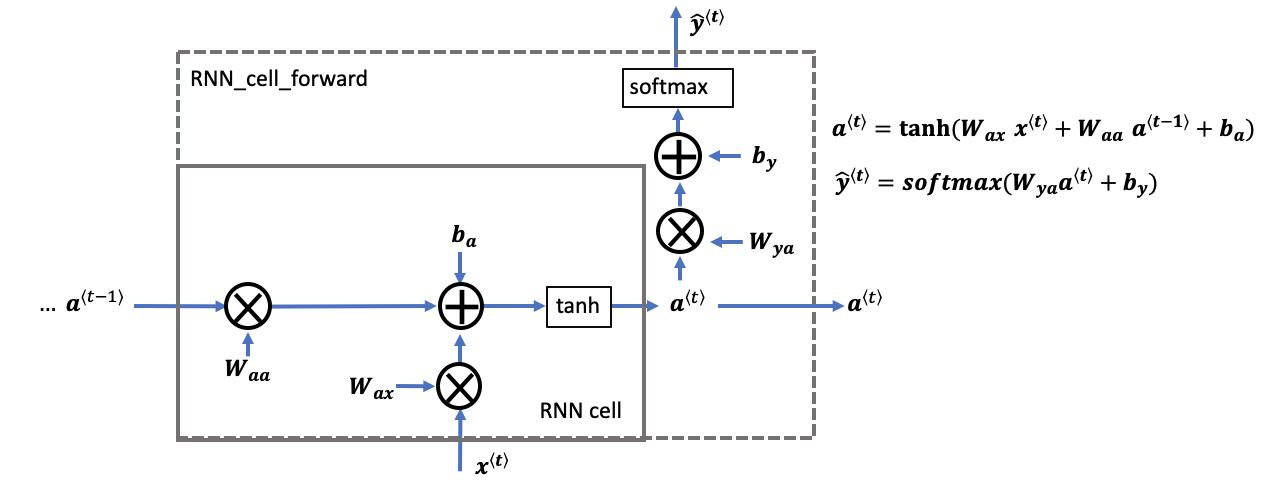

Basic RNN cell. Takes as input  𝑥⟨𝑡⟩  (current input) and  𝑎⟨𝑡−1⟩  (previous hidden state containing information from the past), and outputs  𝑎⟨𝑡⟩  which is given to the next RNN cell and also used to predict  𝑦̂ ⟨𝑡⟩

In [ ]:
def rnn_cell_forward(xt, a_prev, parameters):
  """
    Implements a single forward step of the RNN-cell

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
  """
  # retrieve parameters from "parameters"
  Wax = parameters["Wax"]
  Waa = parameters["Waa"]
  Wya = parameters["Wya"]
  ba = parameters["ba"]
  by = parameters["by"]

  # compute next activation state
  a_next = np.tanh(np.dot(Waa, a_prev)+np.dot(Wax, xt)+ba)

  # compute output of the current cell
  yt_pred = softmax(np.dot(Wya, a_next)+by)

  # store values needed for backward propagation in cache
  cache = (a_next, a_prev, xt, parameters)

  return a_next, yt_pred, cache

A recurrent neural network is a repetition of t he previous RNN cell.

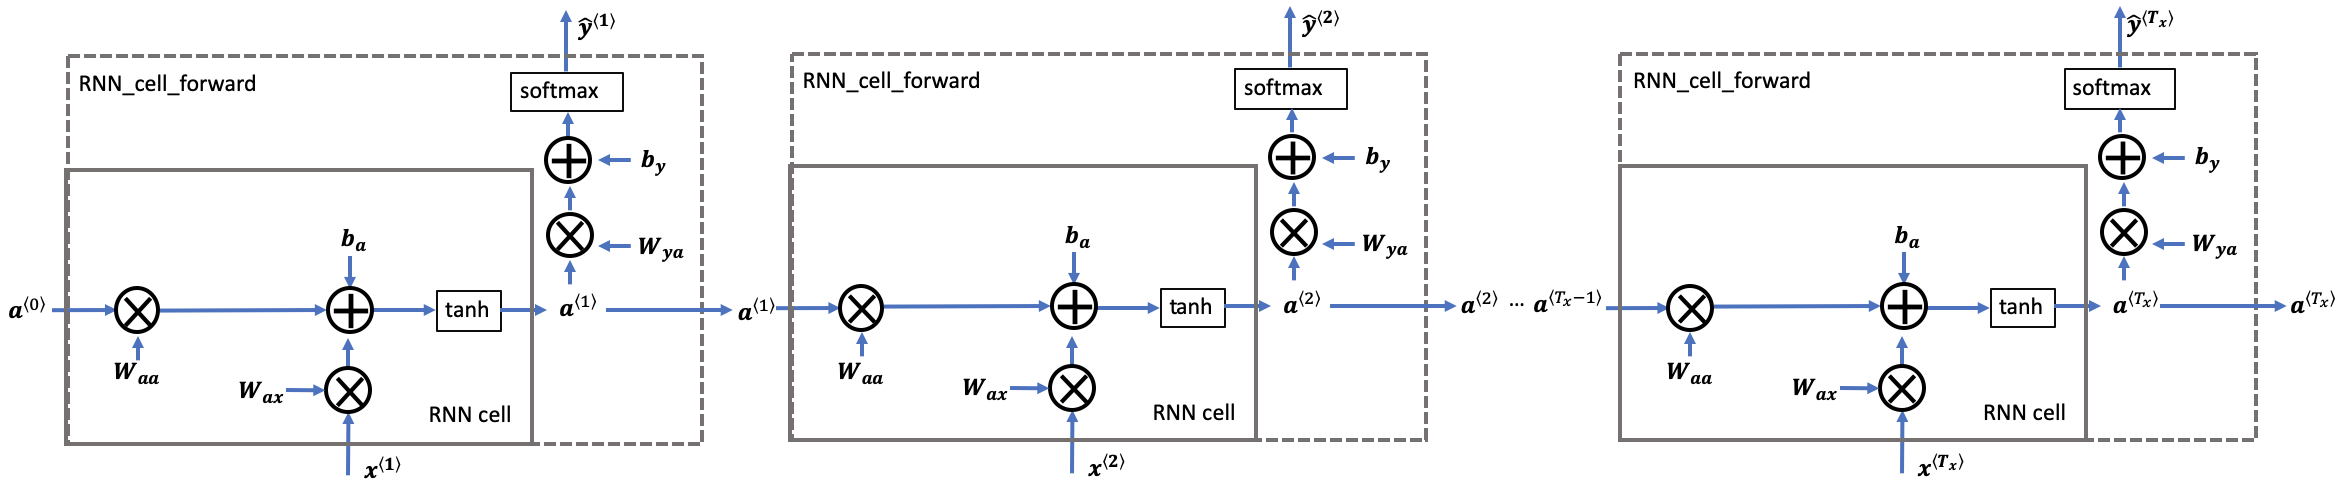

In [ ]:
def rnn_forward(x, a0, parameters):
  """
    Implement the forward propagation of the recurrent neural network.
    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
  """
  # initialize "caches" which will conatain the list of all the caches
  caches = []

  # retrieve dimensions from shapes of x and parameters["Wya"]
  n_x, m, T_x = x.shape
  n_y, n_a = parameters["Wya"].shape

  # initialize "a" and "y_pred" with zeros
  a = np.zeros((n_a, m, T_x))
  y_pred = np.zeros((n_y, m, T_x))
  
  # initialize a_next
  a_next = a0

  # loop over all time-steps
  for t in range(T_x):
    # Update next hidden state, compute the prediction, get the cache (≈1 line)
    a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
    # Save the value of the new "next" hidden state in a (≈1 line)
    a[:,:,t] = a_next
    # Save the value of the prediction in y (≈1 line)
    y_pred[:,:,t] = yt_pred
    # Append "cache" to "caches" (≈1 line)
    caches.append(cache)
  
  # store values needed for backwared propagation in cache
  caches = (caches, x)

  return a, y_pred, caches



*   The recurrent neural network, or RNN, is essentially the repeated use of a single cell.

*   A basic RNN reads inputs one at a time, and remembers information through the hidden layer activations (hidden states) that are passed from one time step to the next.

  *   The time step dimension determines how many times to re-use the RNN cell.
*   Each cell takes two inputs at each time step: The hidden state from the previous cell and the current time step's input data.
*   Each cell has two outputs at each time step: A hidden state and a prediction.


This will work well enough for some applications, but it suffers from **vanishing gradients**.

# Long Short-term Memory (LSTM) Network

The following figure shows the operations of an LSTM cell:

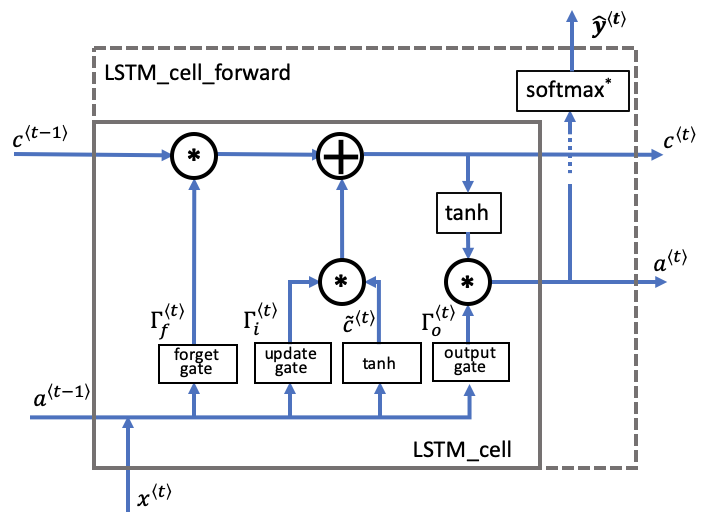
<caption><center><font color='purple'><b>Figure 4</b>: LSTM cell. This tracks and updates a "cell state," or memory variable $c^{\langle t \rangle}$ at every time step, which can be different from $a^{\langle t \rangle}$.  
Note, the $softmax^{}$ includes a dense layer and softmax.</center></caption>


In [ ]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
  """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
  """

  # retrieve parameters from "parameters"
  Wf = parameters["Wf"] # forget gate weight
  bf = parameters["bf"]
  Wi = parameters["Wi"] # update gate weight (notice the variable name)
  bi = parameters["bi"] # (notice the variable name)
  Wc = parameters["Wc"] # candidate value weight
  bc = parameters["bc"]
  Wo = parameters["Wo"] # output gate weight
  bo = parameters["bo"]
  Wy = parameters["Wy"] # prediction weight
  by = parameters["by"]
    
  # retrieve dimensions from shapes of xt and Wy
  n_x, m = xt.shape
  n_y, n_a = Wy.shape

  # concatenate a_prev and xt
  concat = np.concatenate((a_prev, xt), axis = 0)

  # compute values for ft, it, cct, c_next, ot, a_next
  ft = sigmoid(np.dot(Wf, concat)+bf)
  it = sigmoid(np.dot(Wi, concat)+bi)
  cct = np.tanh(np.dot(Wc, concat)+bc)
  c_next = ft * c_prev + it * cct
  ot = sigmoid(np.dot(Wo, concat)+bo)
  a_next = ot * np.tanh(c_next)

  # compute prediction of the LSTM cell
  yt_pred = softmax(np.dot(Wy, a_next) + by)

  # store values needed for backward propagation in cache
  cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

  return a_next, c_next, yt_pred, cache

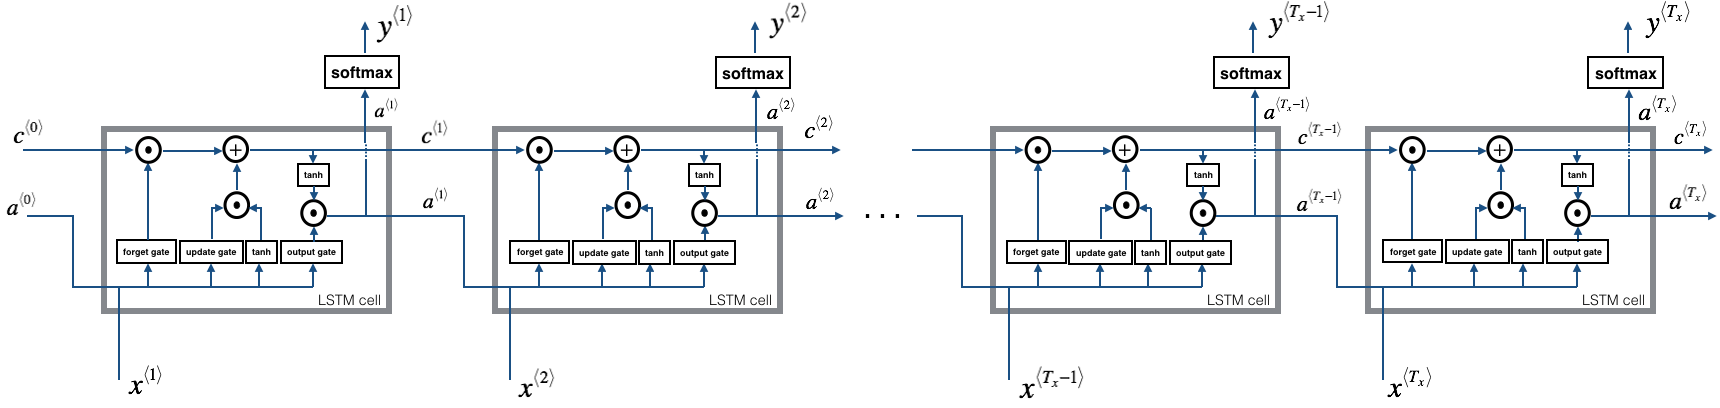

In [ ]:
def lstm_forward(x, a0, parameters):
  """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell.
    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
  """
  # initialize "caches", which will track the list of all the caches
  caches = []

  # retrieve dimensions from shapes of x and parameters['Wy']
  n_x, m, T_x = x.shape
  n_y, n_a = parameters["Wy"].shape

  # initialize "a", "c" and "y" with zeros
  a = np.zeros((n_a, m, T_x))
  c = np.zeros((n_a, m, T_x))
  y = np.zeros((n_y, m, T_x))

  # initialize a_next and c_next
  a_next = a0
  c_next = np.zeros((n_a, m))

  # loop over all time-steps
  for t in range(T_x):
    # Get the 2D slice 'xt' from the 3D input 'x' at time step 't'
    xt = x[:,:,t]
    # Update next hidden state, next memory state, compute the prediction, get the cache
    a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
    # Save the value of the new "next" hidden state in a
    a[:,:,t] = a_next
    # Save the value of the next cell state
    c[:,:,t]  = c_next
    # Save the value of the prediction in y
    y[:,:,t] = yt
    # Append the cache into caches
    caches.append(cache)
  
  # store values needed for backward propagation in cache
  caches = (caches, x)

  return a, y, c, caches

*   An LSTM is similar to an RNN in that they both use hidden states to pass along information, but an LSTM also uses a cell state, which is like a long-term memory, to help deal with the issue of vanishing gradients

*   An LSTM cell consists of a cell state, or long-term memory, a hidden state, or short-term memory, along with 3 gates that constantly update the relevancy of its inputs:
  *   A forget gate, which decides which input units should be remembered and passed along. It's a tensor with values between 0 and 1.
        *   If a unit has a value close to 0, the LSTM will "forget" the stored state in the previous cell state.
        *   If it has a value close to 1, the LSTM will mostly remember the corresponding value.
  *   An update gate, again a tensor containing values between 0 and 1. It decides on what information to throw away, and what new information to add.
      *   When a unit in the update gate is close to 1, the value of its candidate is passed on to the hidden state.
      *   When a unit in the update gate is close to 0, it's prevented from being passed onto the hidden state.

  *   And an output gate, which decides what gets sent as the output of the time ste



When using a deep learning framework, implementing the forward pass is sufficient to build systems that achieve great performance. The framework will take care of the rest.



#  Backpropagation in Recurrent Neural Networks

Note that this notebook does not implement the backward path from the Loss 'J' backwards to 'a'. This would have included the dense layer and softmax, which are a part of the forward path. This is assumed to be calculated elsewhere and the result passed to rnn_backward in 'da'. It is further assumed that loss has been adjusted for batch size (m) and division by the number of examples is not required here.

## Basic RNN Backward Pass



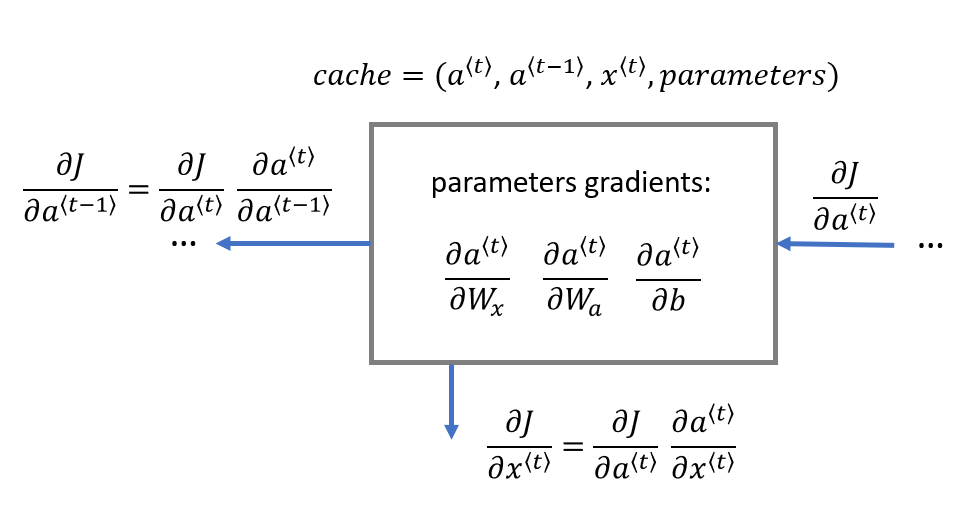
 <br>
<caption><center><font color='purple'><b>Figure 6</b>: The RNN cell's backward pass. Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the time steps of the RNN by following the chain rule from calculus. Internal to the cell, the chain rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$. The operation can utilize the cached results from the forward path. </center></caption>

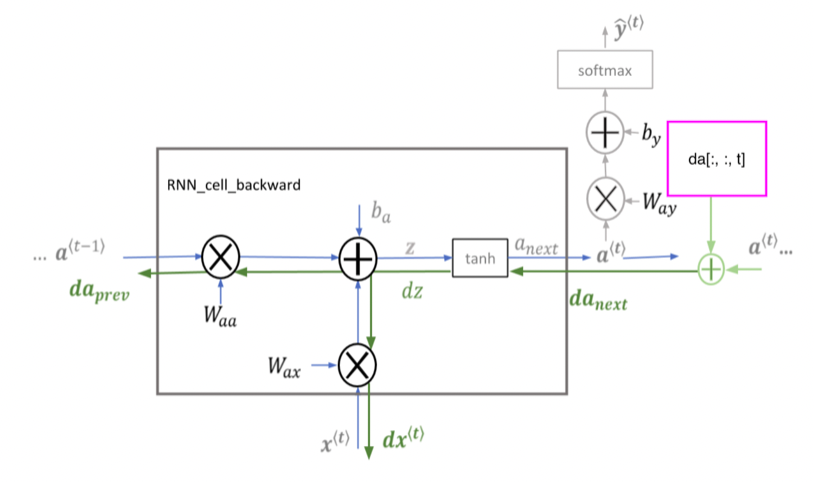

<br>
<caption><center><font color='purple'><b>Figure 7</b>: This implementation of `rnn_cell_backward` does **not** include the output dense layer and softmax which are included in `rnn_cell_forward`.  

$da_{next}$ is $\frac{\partial{J}}{\partial a^{\langle t \rangle}}$ and includes loss from previous stages and current stage output logic. The addition shown in green will be part of your implementation of `rnn_backward`.  </center></caption>

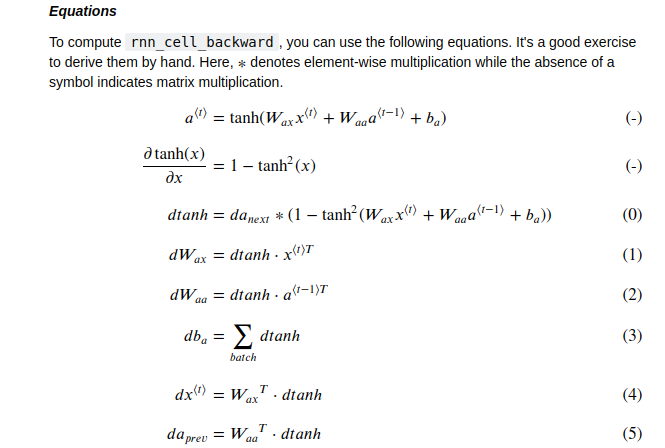

In [ ]:
def rnn_cell_backward(da_next, cache):
  """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
  """

  # retrieve values from cache
  (a_next, a_prev, xt, parameters) = cache

  # retrieve values from parameters
  Wax = parameters["Wax"]
  Waa = parameters["Waa"]
  Wya = parameters["Wya"]
  ba = parameters["ba"]
  by = parameters["by"]

  # compute the gradient of dtanh term using a_next and da_next
  dtanh = (1 - a_next ** 2) * da_next

  # compute the gradient of the loss with respect to Wax
  dxt = np.dot(Wax.T, dtanh)
  dWax = np.dot(dtanh, xt.T)

  # compute the gradient with respect to Waa
  da_prev = np.dot(Waa.T, dtanh)
  dWaa = np.dot(dtanh, a_prev.T)

  # compute the gradient with respect to b
  dba = np.sum(dtanh, axis = 1,keepdims=1)

  # store the gradients in a python dictionary
  gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
  return gradients

In [ ]:
def rnn_backward(da, caches):
  """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
  """
  # retrieve values from the first cache (t=1) of caches
  (caches, x) = caches
  (a1, a0, x1, parameters) = caches[0]

  # retrieve dimensions from da's and x1's shapes
  n_a, m, T_x = da.shape
  n_x, m = x1.shape

  # initialize the gradients with the right sizes
  dx = np.zeros((n_x, m, T_x))
  dWax = np.zeros((n_a, n_x))
  dWaa = np.zeros((n_a, n_a))
  dba = np.zeros((n_a, 1))
  da0 = np.zeros((n_a, m))
  da_prevt = np.zeros((n_a, m))

  # loop through all the time steps
  for t in reversed(range(T_x)):
    # Compute gradients at time step t.
    gradients = rnn_cell_backward(da[:,:,t] + da_prevt, caches[t])
    # Retrieve derivatives from gradients
    dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
    # Increment global derivatives w.r.t parameters by adding their derivative at time-step t
    dx[:, :, t] = dxt
    dWax +=dWaxt
    dWaa +=dWaat
    dba +=dbat

  # Set da0 to the gradient of a which has been backpropagated through all time-steps
  da0 = da_prevt
  
  # store the gradients in a python dictionary
  gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
  
  return gradients

## LSTM backward Pass

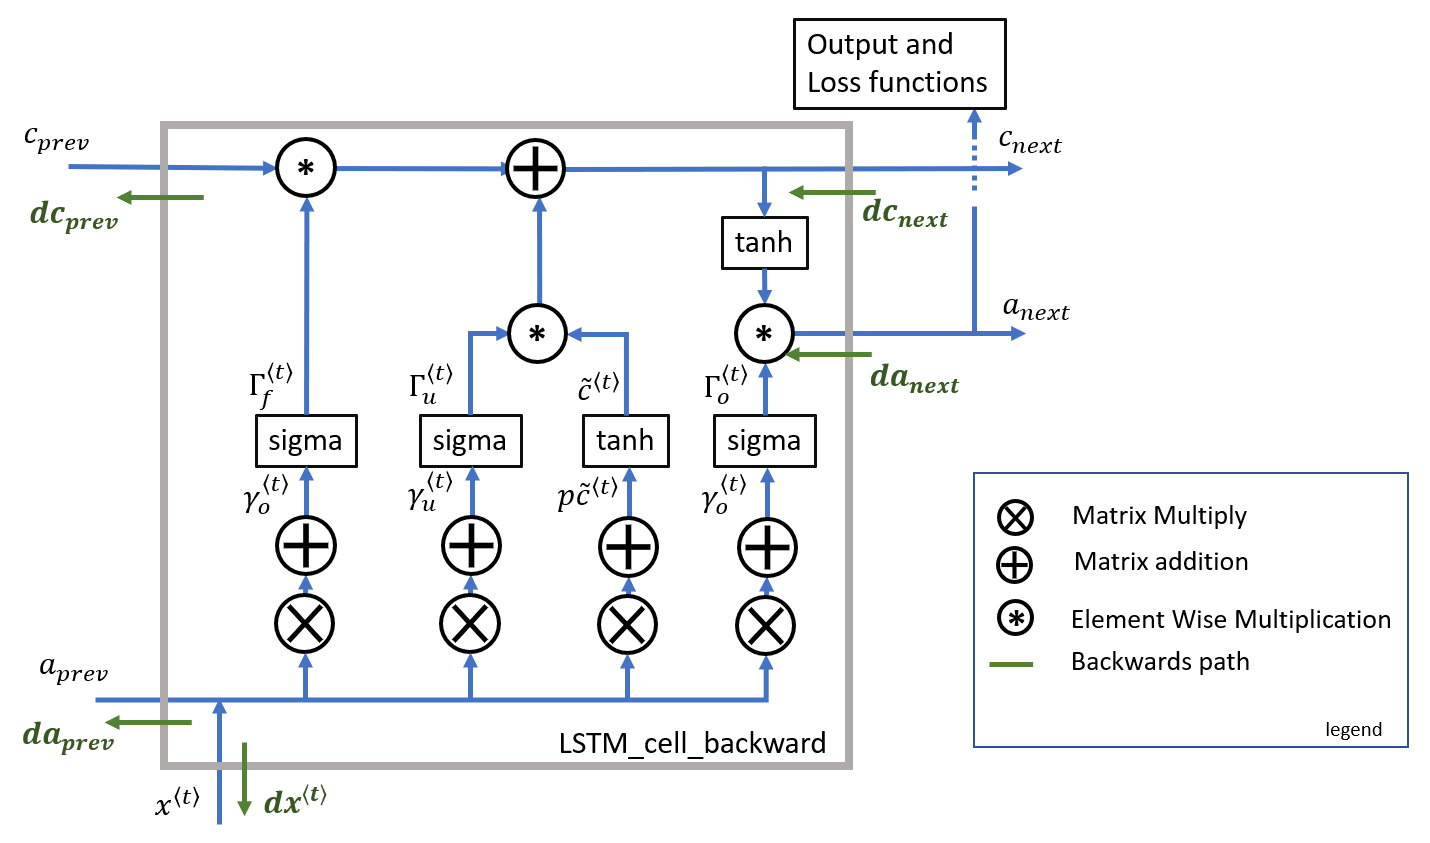

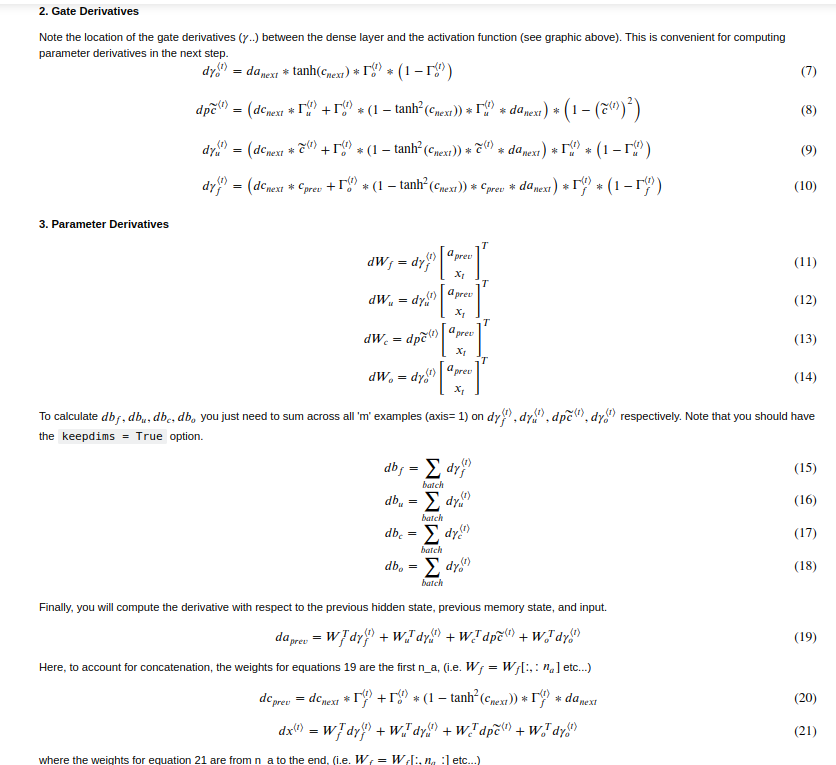

In [ ]:
def lstm_cell_backward(da_next, dc_next, cache):
  """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
  """

  # retrieve information from "cache"
  (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache

  # retrieve dimensions from xt's and a_next's shape
  n_x, m = xt.shape
  n_a, m = a_next.shape

  # compute gates related derivatives.
  dot = da_next*np.tanh(c_next)*ot*(1-ot)
  dcct = (dc_next*it+ot*(1-np.square(np.tanh(c_next)))*it*da_next)*(1-np.square(cct))
  dit = (dc_next*cct+ot*(1-np.square(np.tanh(c_next)))*cct*da_next)*it*(1-it)
  dft = (dc_next*c_prev+ot*(1-np.square(np.tanh(c_next)))*c_prev*da_next)*ft*(1-ft)

  # compute parameters related derivatives. Use equations (11)-(18)
  dWf = np.dot(dft, np.hstack([a_prev.T, xt.T]))
  dWi = np.dot(dit, np.hstack([a_prev.T, xt.T]))
  dWc = np.dot(dcct, np.hstack([a_prev.T, xt.T]))
  dWo = np.dot(dot, np.hstack([a_prev.T, xt.T]))
  dbf = np.sum(dft, axis=1, keepdims=True)
  dbi = np.sum(dit, axis=1, keepdims=True)
  dbc = np.sum(dcct, axis=1, keepdims=True)
  dbo = np.sum(dot, axis=1, keepdims=True)

  # compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (19)-(21).
  da_prev = np.dot(parameters['Wf'][:,:n_a].T,dft)+np.dot(parameters['Wi'][:,:n_a].T,dit)+np.dot(parameters['Wc'][:,:n_a].T,dcct)+np.dot(parameters['Wo'][:,:n_a].T,dot)
  dc_prev = dc_next*ft+ot*(1-np.square(np.tanh(c_next)))*ft*da_next
  dxt = np.dot(parameters['Wf'][:,n_a:].T,dft)+np.dot(parameters['Wi'][:,n_a:].T,dit)+np.dot(parameters['Wc'][:,n_a:].T,dcct)+np.dot(parameters['Wo'][:,n_a:].T,dot)    
    
  # Save gradients in dictionary
  gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

  return gradients

In [ ]:
def lstm_backward(da, caches):
  """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    dc -- Gradients w.r.t the memory states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
  """

  # retrieve values from the first cache (t=1) of caches.
  (caches, x) = caches
  (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]

  # Retrieve dimensions from da's and x1's shapes.
  n_a, m, T_x = da.shape
  n_x, m = x1.shape

  # initialize the gradients with the right sizes
  dx = np.zeros((n_x, m, T_x))
  da0 = np.zeros((n_a, m))
  da_prevt = np.zeros((n_a, m))
  dc_prevt = np.zeros((n_a, m))
  dWf = np.zeros((n_a, n_a + n_x))
  dWi = np.zeros((n_a, n_a + n_x))
  dWc = np.zeros((n_a, n_a + n_x))
  dWo = np.zeros((n_a, n_a + n_x))
  dbf = np.zeros((n_a, 1))
  dbi = np.zeros((n_a, 1))
  dbc = np.zeros((n_a, 1))
  dbo = np.zeros((n_a, 1))

  # loop back over the whole sequence
  for t in reversed(range(T_x)):
    # Compute all gradients using lstm_cell_backward
    gradients = lstm_cell_backward(da[:,:,t]+da_prevt,dc_prevt,caches[t])
    # Store or add the gradient to the parameters' previous step's gradient
    da_prevt = gradients['da_prev']
    dc_prevt = gradients['dc_prev']
    dx[:, :, t] = gradients['dxt']
    dWf = dWf+gradients['dWf']
    dWi = dWi+gradients['dWi']
    dWc = dWc+gradients['dWc']
    dWo = dWo+gradients['dWo']
    dbf = dbf+gradients['dbf']
    dbi = dbi+gradients['dbi']
    dbc = dbc+gradients['dbc']
    dbo = dbo+gradients['dbo']
  # Set the first activation's gradient to the backpropagated gradient da_prev.
  da0 = gradients['da_prev']

  # Store the gradients in a python dictionary
  gradients = {"dx": dx, "da0": da0, "dWf": dWf, "dbf": dbf, "dWi": dWi, "dbi": dbi,
                 "dWc": dWc, "dbc": dbc, "dWo": dWo, "dbo": dbo}

  return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)

parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.zeros((2,5))       # unused, but needed for lstm_forward
parameters_tmp['by'] = np.zeros((2,1))       # unused, but needed for lstm_forward

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)

da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = lstm_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dx"][1][2] = [ 0.00218254  0.28205375 -0.48292508 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = 0.3127703102572603
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.08098023109383466
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.4051243309298186
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.07937467355121491
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.03894877576298697
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.15745657]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.50848333]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.42510818]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.17958196]
gradients["dbo"].shape = (5, 1)
